# Examples to Show the Usage of the Random Phase Approximation

In [1]:
# Here are the models stored to obtain the Hamiltonian in k-space.
from hamiltonian import Hubbard, T2G
# This is the class to run RPA calculations.
from rpa import RandomPhaseApproximation
# This class is used to construct physical values.
from operators import Susceptibilities, Operators

import matplotlib.pyplot as plt
%matplotlib inline

Starting on 1 Nodes at : 2018-11-20 18:47:28.243695


## The Model Part

We start of by constructing a one band Hubbard model. We treat every band as two orbitals one having spin up, the other spin down. Therefore shape of H(k) is 2x2.
The only mandatory parameter are:
1. `k_mesh`: A Sequence like object giving the number of point to scan over for every dimension.
2. `t`: The strength of the nearest neighbor hopping.
With the creation of the object a H(k) will be automatically created.
The shape is the k_mesh + (orbital, orbitals).

In [2]:
k_mesh = 4

ham_hubbard_parameters = {"k_mesh" : (k_mesh, k_mesh),
                          "t" : 1.0}
ham_hubbard = Hubbard(**ham_hubbard_parameters)
print(ham_hubbard.hamK.shape)

(4, 4, 2, 2)


This class can also be used to calculate the chemical potential for a specific filling.

In [3]:
ham_hubbard.get_chemical_potential(1.0)


Calculate the chemical potential
Iteration 1
Density difference = 4.252265206616812e-12
Final chemical potential: -0.0 eV


-0.0

## The Random Phase Approximation

Next we create the RandomPhaseApproximation object.
As an input it needs:
1. `hamiltonian`: A np.ndarray as the one that the Hubbard class produces.
2. `chemical_potential`: Use the one from the previous calculation or set to anything.
3. `beta`: The inverse temperature.
4. `iw_mesh`: The number of points in fermionic frequency space in one direction.
5. `U`: The intra-orbital interaction strength.

Also you can give the parameters `Up`, `J` and `Jp` as the Kanamori interaction parameters for larger systems.

In [4]:
rpa_parameters = {"chemical_potential" : 0.0,
                 "beta" : 10,
                 "iw_mesh" : 512,
                 "U" : 1.0}
rpa = RandomPhaseApproximation(ham_hubbard.hamK, **rpa_parameters)

You can now construct everything step by step.
First the Greensfunctions.

In [5]:
rpa.construct_gf()

100%|██████████| 4/4 [00:00<00:00, 660.18it/s]


Constructing the GF tensor
Construct GreensFunctions.

Combining the GF tensor at the master.

Prepare the GF tensor.


Then the chi0. Here you can give specifc truncations to speed up further calculations if you are only interested in specifc points:

```python
"""
Parameters
----------
freq_truncation : str 'static', int or slice
                    Using the string 'static' will keep only keep the data for the frequency closest to zero.
                    Unsing an int will only keep the data for the frequency at the index of the int.
                    Using a slice object keeps the data for a range of freuencies.
reci_truncation : str 'uniform', sequence like of ints,
                                sequence like of sequence like of ints
                                
                    Using the string 'uniform' will only keep the data at the Gamma point.
                    Using a Sequence like object filled with ints will only keep the data for a specific k-point.
                    Using a Sequence like object filled with Sequence like objects filled with ints is like
                    entering multiple k-points. This will result in keeping the data for all k-points on a path
                    through the points given. For this to work the path of the given points must lie on the mesh 
                    points.
"""
```

In [6]:
rpa.construct_chi0()

100%|██████████| 1/1 [00:00<00:00, 28.37it/s]


Constructing the Chi0 tensor


At last the chiRPA has to be calculated.

In [7]:
rpa.construct_chiRPA()


Constructing the ChiRPA tensor


Or you could just use the function `do_rpa` to do all of that.
It will only run specifc tasks if parameters were changed.
So if you run it now nothing will happen.

In [8]:
rpa.do_rpa()

But if you change an interaction parameter of rpa it needs ro rerun `construct_chiRPA`.

In [9]:
rpa.U = 1.1
rpa.do_rpa()


Constructing the ChiRPA tensor


If you change a parameter that changes the model and not just the interaction all steps have to be rerun.

In [10]:
rpa.chemical_potential = 0.1
rpa.do_rpa()

100%|██████████| 1/1 [00:00<00:00, 31.87it/s]


Constructing the Chi0 tensor

Constructing the ChiRPA tensor


## The Output as a Greensfunction

This is how to work with `RandomPhaseApproximation`, now let's look at the ouput data.

Everything that is calculated is stored as an attribute of rpa (except the GF, they are deleted after to calculation of chi0 to save memory).
It is stored as a GreensFunctionContainer object.
```python
class GreensFunctionContainer(defaultdict):
    """
    Dictionary like container to manage GreensFunction objects

    The GreensFunctionContainer object subclasses the defaultdict object, i.e. if one tries to
    access a key that is not accessable for this key the default object will be returned and 
    stored. One should use GreensFunctions objects as default objects.

    It has the ability to access values for keys that are not directly stored, but use a mapping.
    If two GreensFunctions are considered equal but stored for different keys, the 
    map_duplicates function will only keep the value once and extend the mapping attribute.
    This is important for memory saving.

    Parameters
    ----------
    Default type of GreensFunction
    """
```
The documentaion for a GreensFunction object is as follows.
```python
class GreensFunction(object):
    """Container that mimics the behaivor of a Greens function
    
    Parameters
    ----------
    shape : iterable of ints, first int gives time_mesh the following determine the space_mesh
    statistic : str, 'Fermion' or 'Boson', type of Greens function
    time : str, 'freq' or 'tau', inital domain of the time data.
    space : str, 'reci' or 'real', inital domain of the space data.
    gamma_centered : bool, True if Gamma point is/shall be in the middle of the data. 
                     False for the beginning.
    """
```

In short, this gives the ability to easily manipulate the ouput data.
Lets look at chi0 as an example.

In [11]:
rpa.chi0

GreensFunctionContainer(<function greensfunction.<lambda>>,
                        {'1111': A Boson GreensFunction in freq- and reci-space of shape (101, 4, 4). Gamma centered: True.})

It contains only one unique GreensFunction. To see all that are non zero we can use.

In [12]:
rpa.chi0.mapping.keys()

['1111', '0110', '0000', '1001']

We can access any of those and have a look at it.

In [13]:
chi0_1111 = rpa.chi0['1111']
chi0_1111

A Boson GreensFunction in freq- and reci-space of shape (101, 4, 4). Gamma centered: True.

We could now for example only access the static part.

In [14]:
chi0_1111.truncate_freq('static')

A Boson GreensFunction in freq- and reci-space of shape (1, 4, 4). Gamma centered: True.

Or transform to real space.

In [15]:
chi0_1111.to_real()

A Boson GreensFunction in freq- and real-space of shape (101, 4, 4). Gamma centered: True.

To see all features checkout the documentation of `GreensFunction` in greensfunction.py

## Susceptibilites

If we now want to obtain physical values from these calculation we need the `Susceptibilites` class.
But before we go there let's see what we even can calculate.

For this we will use the `Operators` class were all stored operators are managed.

In [16]:
op = Operators()
op

Orbs	Operators
{'2': ['LS',
       'Lx',
       'Ly',
       'Lz',
       'Smin',
       'Splus',
       'Sx',
       'Sy',
       'Sz',
       'n',
       'ndown',
       'nup'],
 '4': ['Smin',
       'Splus',
       'Sx',
       'Sy',
       'Sz',
       'n',
       'ndown',
       'nup'],
 '6': ['LS',
       'Lx',
       'Ly',
       'Lz',
       'Smin',
       'Splus',
       'Sx',
       'Sy',
       'Sz',
       'n',
       'ndown',
       'nup']}

This gives a list of what operators are implemented for which number of orbitals.
From these we can choose which two-particle response functions we want to calculate.
Let's choose $<\hat{S}_\text{z}\hat{S}_\text{z}>$ and $<\hat{n}\hat{n}>$

In [17]:
operator_pairs = [('Sz', 'Sz'), ('n', 'n')]

This we have to tell the `Susceptibilies` class and also the number of orbitals our system has.

In [18]:
sus = Susceptibilities(operator_pairs, orbitals=2)

Now it needs a `GreensFunctionContainer` as an input to calculate the two-particle response functions that we want.
It will then store all of them in a `GreensFunctionContainer` under the attribute `susceptibilites`.

In [19]:
sus.calculate_susceptibilities(rpa.chi0)
sus.susceptibilites

GreensFunctionContainer(None,
                        {'SzSz': A Boson GreensFunction in freq- and reci-space of shape (101, 4, 4). Gamma centered: True.,
                         'nn': A Boson GreensFunction in freq- and reci-space of shape (101, 4, 4). Gamma centered: True.})

We can now access them and manipulate as we want.

## Walktrough of the one-band Hubbard Model

In [20]:
k_mesh = 64

ham_hubbard_parameters = {"k_mesh" : (k_mesh, k_mesh),
                          "t" : 1.0}
ham_hubbard = Hubbard(**ham_hubbard_parameters)

We can now only calculate the path through high-symmetry points. Because we constructed the H(k) we obviously know where they are and can state them.
Let's use $\Gamma-X-M-\Gamma$.

In [21]:
path = [ [k_mesh/2, k_mesh/2], [0, k_mesh/2], [0,0], [k_mesh/2, k_mesh/2]]

In [22]:
rpa_parameters = {"chemical_potential" : 0.0,
                 "beta" : 10,
                 "iw_mesh" : 512,
                 "U" : 1.0}
rpa = RandomPhaseApproximation(ham_hubbard.hamK, **rpa_parameters)
rpa.do_rpa(reci_truncation=path)

  1%|          | 47/4096 [00:00<00:08, 461.60it/s]


Constructing the GF tensor
Construct GreensFunctions.


  0%|          | 0/4 [00:00<?, ?it/s]


Combining the GF tensor at the master.


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]



Prepare the GF tensor.


  0%|          | 0/1 [00:00<?, ?it/s]


Constructing the Chi0 tensor


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Constructing the ChiRPA tensor


In [23]:
operator_pairs = [('Sz', 'Sz'), ('n', 'n')]
sus = Susceptibilities(operator_pairs, orbitals=2)
sus.calculate_susceptibilities(rpa.chiRPA)

SzSz_U1 = sus.susceptibilites['SzSz'].copy().truncate_freq('static')

We could now lowere the interaction strength.

In [24]:
rpa.U = 0.5
rpa.do_rpa()

sus.calculate_susceptibilities(rpa.chiRPA)

SzSz_U05 = sus.susceptibilites['SzSz'].copy().truncate_freq('static')


Constructing the ChiRPA tensor


A plotting library or something of that sort is not yet implemented, so let's just use this function here.

In [25]:
import numpy as np

def path_plotting(path):
    plot_path = []
    high_symmetry = [0]
    for start, stop in zip(path, path[1:]):
        if start == path[0]:
            prev = 0
        else:
            prev = plot_path[-1]
        start, stop = np.array(start), np.array(stop)
        diff = start - stop
        non_zero = [abs(ele) for ele in diff if ele!=0]
        factor = np.sqrt(len(non_zero))
        steps = non_zero[0]
        if list(stop) == path[-1]:
            steps += 1
        plot_path_extension = np.arange(prev, prev+steps*factor, factor)
        plot_path.extend(plot_path_extension)
        high_symmetry.append(plot_path_extension[-1])
    return plot_path, high_symmetry

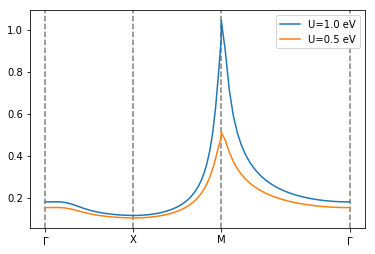

In [26]:
plot_path, high_symmetry = path_plotting(path)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticks(high_symmetry)
ax.set_xticklabels(['$\Gamma$', 'X', 'M', '$\Gamma$'])
for x in high_symmetry:
    ax.axvline(x, ls="--", color='grey')

ax.plot(plot_path, SzSz_U1.data[0], label='U=1.0 eV')
ax.plot(plot_path, SzSz_U05.data[0], label='U=0.5 eV')
ax.legend()

Or we could calculate the susceptibilites for the whole BZ, but only static.
And then plot the whole BZ in different ways or plot the susceptibiliy for the real-space lattice to better show the ordering.

In [27]:
rpa_parameters = {"chemical_potential" : 0.0,
                 "beta" : 10,
                 "iw_mesh" : 512,
                 "U" : 1.3}
rpa = RandomPhaseApproximation(ham_hubbard.hamK, **rpa_parameters)
rpa.do_rpa(freq_truncation='static')

  1%|          | 51/4096 [00:00<00:07, 507.43it/s]


Constructing the GF tensor
Construct GreensFunctions.


  0%|          | 0/4 [00:00<?, ?it/s]


Combining the GF tensor at the master.


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]



Prepare the GF tensor.


  0%|          | 0/1 [00:00<?, ?it/s]


Constructing the Chi0 tensor


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Constructing the ChiRPA tensor


In [28]:
sus.calculate_susceptibilities(rpa.chiRPA)

SzSz_BZ = sus.susceptibilites['SzSz'].copy()

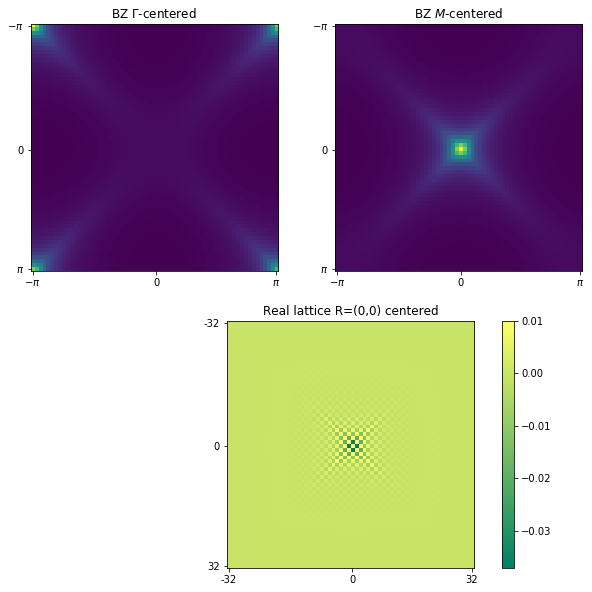

In [29]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,2), (0,0), colspan=1)
ax2 = plt.subplot2grid((2,2), (0,1), colspan=1)
ax3 = plt.subplot2grid((2,2), (1,0), colspan=2)

ax1.imshow(SzSz_BZ.data[0])
ax1.set_title("BZ $\Gamma$-centered")
ax1.set_xticks([0, k_mesh/2, k_mesh-1])
ax1.set_xticklabels(["$-\pi$", "0", "$\pi$"])
ax1.set_yticks([0, k_mesh/2, k_mesh-1])
ax1.set_yticklabels(["$-\pi$", "0", "$\pi$"])

ax2.imshow(SzSz_BZ.move_gamma().data[0])
ax2.set_title("BZ $M$-centered")
ax2.set_xticks([0, k_mesh/2, k_mesh-1])
ax2.set_xticklabels(["$-\pi$", "0", "$\pi$"])
ax2.set_yticks([0, k_mesh/2, k_mesh-1])
ax2.set_yticklabels(["$-\pi$", "0", "$\pi$"])

pl = ax3.imshow(SzSz_BZ.to_real().move_gamma().data[0].real, cmap='summer', vmax=0.01)
ax3.set_title("Real lattice R=(0,0) centered")
ax3.set_xticks([0, k_mesh/2, k_mesh-1])
ax3.set_xticklabels([str(-k_mesh/2), "0", str(k_mesh/2)])
ax3.set_yticks([0, k_mesh/2, k_mesh-1])
ax3.set_yticklabels([str(-k_mesh/2), "0", str(k_mesh/2)])
plt.colorbar(pl)

## Benchmark for the 3-Dimensional t2g-Model

In [30]:
k_mesh = 8

ham_t2g_parameters = {"k_mesh" : (k_mesh, k_mesh, k_mesh),
                      "t" : 1.0,
                      "tprime" : 0.1,
                      "soc" : 0.1,
                      "cf" : 0.2}

ham_t2g = T2G(**ham_t2g_parameters)

In [31]:
path = [ [k_mesh/2, k_mesh/2, k_mesh/2],
         [0, k_mesh/2, k_mesh/2],
         [0, 0, k_mesh/2],
         [0, 0, 0],
         [k_mesh/2, k_mesh/2, k_mesh/2] ]

In [32]:
rpa_parameters = {"chemical_potential" : 0.0,
                 "beta" : 10,
                 "iw_mesh" : 512,
                 "U" : 1.0,
                 "Up" : 0.8,
                 "J" : 0.1,
                 "Jp" : 0.1}

rpa = RandomPhaseApproximation(ham_t2g.hamK, **rpa_parameters)

In [33]:
%timeit -n 1 -r 1 rpa.do_rpa(freq_truncation='static', reci_truncation=path)

  3%|▎         | 14/512 [00:00<00:03, 139.52it/s]


Constructing the GF tensor
Construct GreensFunctions.


 11%|█         | 4/36 [00:00<00:01, 31.54it/s]


Combining the GF tensor at the master.


100%|██████████| 36/36 [00:01<00:00, 30.87it/s]



Prepare the GF tensor.


  0%|          | 0/81 [00:00<?, ?it/s]


Constructing the Chi0 tensor


100%|██████████| 81/81 [00:33<00:00,  2.45it/s]


Constructing the ChiRPA tensor
1 loop, best of 1: 41 s per loop
